Packages

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

## 1 Pricing and hedging by Monte Carlo

### 1.1 Finite differences approach

Functions

In [2]:
def GeneratePathsHestonEuler(S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float, kappa: float,
                             theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1):
    """
    Inputs:
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
    Outputs:
     - asset prices over time (2D array)
    """
    np.random.seed(seed)
    dt = maturity / nb_steps
    mu = np.array([0, 0])
    cov = np.array([[1, rho],
                    [rho, 1]])
    S = np.full(shape=(nb_steps + 1, nb_simuls), fill_value=float(S0))
    v = np.full(shape=(nb_steps + 1, nb_simuls), fill_value=float(v0))
    Z = np.random.multivariate_normal(mu, cov, (nb_steps, nb_simuls))
    for i in range(1, nb_steps + 1):
        S[i] = S[i - 1] * np.exp((risk_free_rate - 0.5 * v[i - 1]) * dt + np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 0])
        v[i] = np.maximum(v[i - 1] + kappa * (theta - v[i - 1]) * dt + sigma * np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 1], 0)
    return S.T


def Payoff(strike: float, barrier: float, S: list):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S              : asset prices over time (1D array)
    Outputs:
     - american D&O Call payoff (float)
    """
    if min(S) <= barrier:
        return 0
    else:
        return max(0, S[-1] - strike)


def MC_Pricing(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
               kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
    Outputs:
     - american D&O Call price (float)
    """
    S_matrix = GeneratePathsHestonEuler(S0=S0, v0=v0, risk_free_rate=risk_free_rate, maturity=maturity, rho=rho,
                                        kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps, nb_simuls=nb_simuls,
                                        seed=seed)
    payoffs = []
    for S in S_matrix:
        payoffs.append(Payoff(strike=strike, barrier=barrier, S=S))
    return np.exp(-risk_free_rate * maturity) * np.mean(payoffs)


def DeltaFD(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
            kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1, dS0=pow(10, -4)):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
     - dS0            : S0 differential (float)
    Outputs:
     - american D&O Call delta (float)
    """
    price_up = MC_Pricing(strike=strike, barrier=barrier, S0=S0+dS0, v0=v0, risk_free_rate=risk_free_rate,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    price_down = MC_Pricing(strike=strike, barrier=barrier, S0=S0-dS0, v0=v0, risk_free_rate=risk_free_rate,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    return (price_up - price_down) / (2 * dS0)


def GammaFD(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
            kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1, dS0=pow(10, -4)):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
     - dS0            : S0 differential (float)
    Outputs:
     - american D&O Call gamma (float)
    """
    price_up = MC_Pricing(strike=strike, barrier=barrier, S0=S0+dS0, v0=v0, risk_free_rate=risk_free_rate,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    price = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                       maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                       nb_simuls=nb_simuls, seed=seed)
    price_down = MC_Pricing(strike=strike, barrier=barrier, S0=S0-dS0, v0=v0, risk_free_rate=risk_free_rate,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    return (price_up - 2 * price + price_down) / (pow(dS0, 2))


def RhoFD(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
          kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1, dr=pow(10, -4)):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
     - dr             : risk_free_rate differential (float)
    Outputs:
     - american D&O Call rho (float)
    """
    price_up = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate+dr,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    price_down = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate-dr,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    return (price_up - price_down) / (2 * dr) / 100


def VegaFD(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
           kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1, dv=pow(10, -4)):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
     - dv             : v0 & theta differential (float)
    Outputs:
     - american D&O Call rho (float)
    """
    price_v0_up = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0+dv, risk_free_rate=risk_free_rate,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    price_v0_down = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0-dv, risk_free_rate=risk_free_rate,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    price_theta_up = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta+dv, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    price_theta_down = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta-dv, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    vega_v0 = (price_v0_up - price_v0_down) / (2 * dv) * 2 * np.sqrt(v0)
    vega_theta = (price_theta_up - price_theta_down) / (2 * dv) * 2 * np.sqrt(theta)
    return (vega_v0 + vega_theta) / 100


def StandardError(Y: list, nb_simuls: int):
    """
    Inputs:
     - Y              : payoffs (1D array)
     - nb_simuls      : number of simulations (int)
    Outputs:
     - Standard error (float)
    """
    return np.sqrt(np.var(Y) / nb_simuls)


Main


Results
 - Price: 8.993915751571558 (0.1s)
 - Delta: 0.3104838590228809 (0.1s)
 - Gamma: -1.7763568394002505e-07 (0.2s)
 - Rho: 0.22054470186159136 (0.1s)
 - Vega: 0.2555519463261582 (0.3s)

Standard Error Evolution Computed (22.0s)


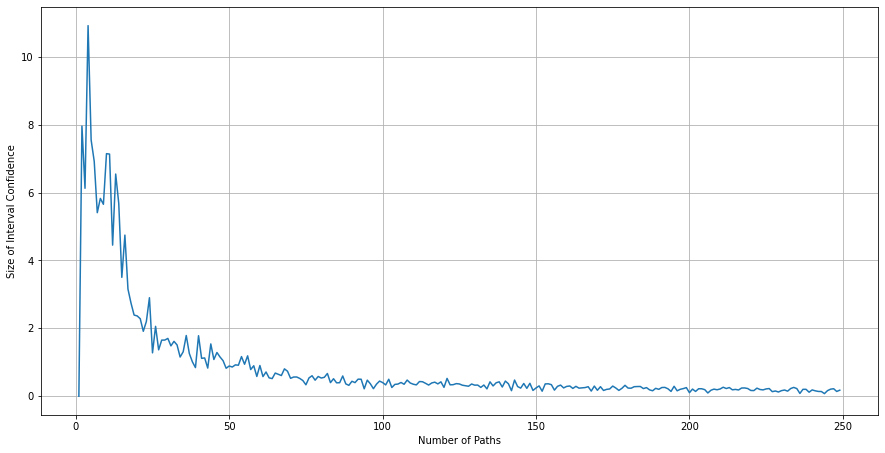

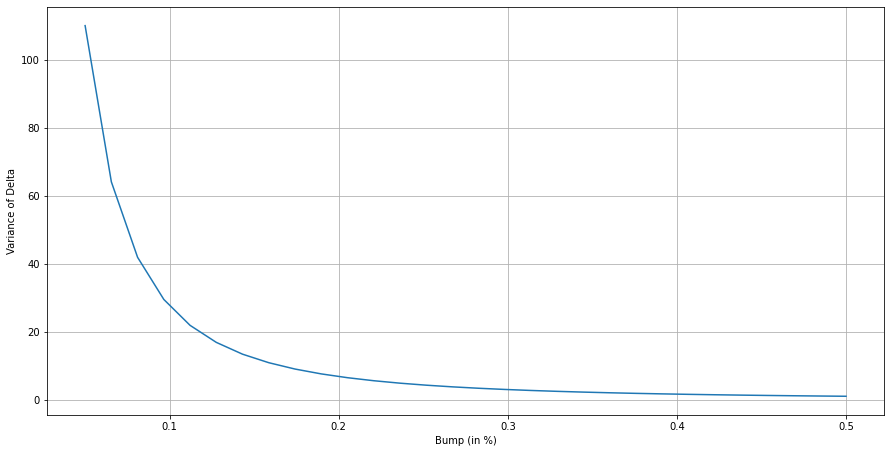

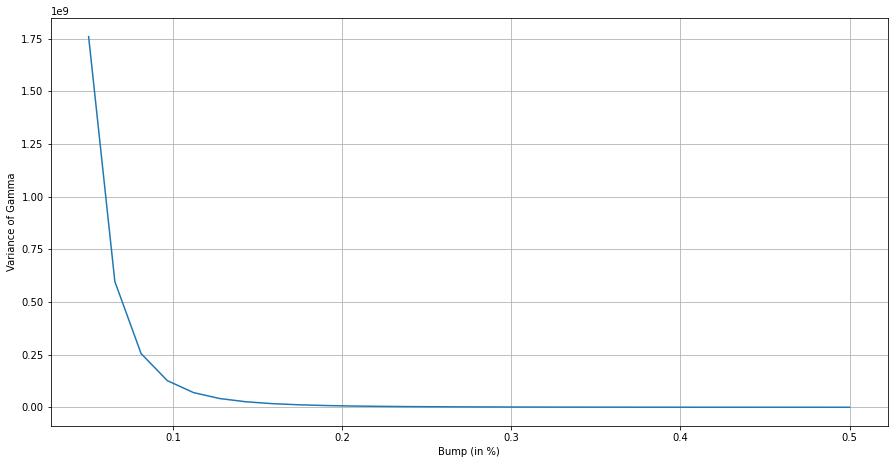

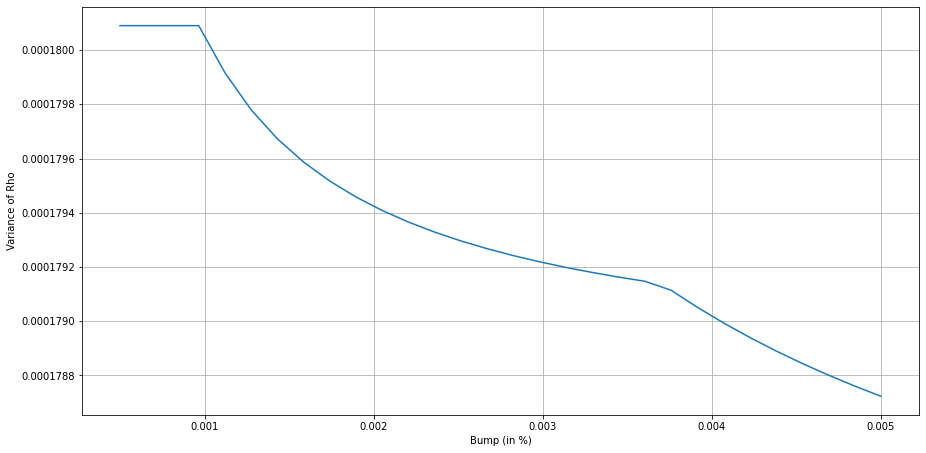

In [3]:
# Down & Out Call Option Parameters
strike = 100
barrier = 90
maturity = 1

# Heston Model Parameters
S0 = 100
v0 = 0.1
rho = -0.9
kappa = 0.1
theta = 0.5
sigma = 0.1
risk_free_rate = 0.02

# Simulations Parameters
seed = 123
nb_steps = 252
nb_simuls = 1000

# -------------------------------------------------------------------------------------------------------------------- #

# Price
start = time.perf_counter()
price = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate, maturity=maturity,
                   rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print("\nResults")
print(f" - Price: {price} ({round(end - start, 1)}s)")

# Delta
start = time.perf_counter()
delta = DeltaFD(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate, maturity=maturity,
                rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print(f" - Delta: {delta} ({round(end - start, 1)}s)")

# Gamma
start = time.perf_counter()
gamma = GammaFD(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate, maturity=maturity,
                rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print(f" - Gamma: {gamma} ({round(end - start, 1)}s)")

# Rho
start = time.perf_counter()
rho = RhoFD(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate, maturity=maturity,
            rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print(f" - Rho: {rho} ({round(end - start, 1)}s)")

# Vega
start = time.perf_counter()
vega = VegaFD(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate, maturity=maturity,
            rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print(f" - Vega: {vega} ({round(end - start, 1)}s)\n")

# Greeks Variance
bump_list = np.linspace(0.05, 0.5, 30)
var_delta_list = []
var_gamma_list = []
var_rho_list = []
for bump in bump_list:
    delta_list = []
    gamma_list = []
    rho_list = []
    for j in range(10):
        delta_list.append(DeltaFD(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                                  maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                                  nb_simuls=nb_simuls, seed=j, dS0=bump/100))
        gamma_list.append(GammaFD(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                                  maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                                  nb_simuls=nb_simuls, seed=j, dS0=bump/100))
        rho_list.append(RhoFD(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                              maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                              nb_simuls=nb_simuls, seed=j, dr=bump/10000))
    var_delta_list.append(np.var(delta_list))
    var_gamma_list.append(np.var(gamma_list))
    var_rho_list.append(np.var(rho_list))

# Standard Error
start = time.perf_counter()
confidence_int_list = []
nb_simuls_list = range(1, 250)
for my_nb_simuls in nb_simuls_list:
    Y_list = []
    for j in range(1, 10):
        Y_list.append(MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                                 maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                                 nb_simuls=my_nb_simuls, seed=j))
    std = StandardError(Y=Y_list, nb_simuls=my_nb_simuls)
    confidence_int_list.append(std*1.96)
end = time.perf_counter()
print(f"Standard Error Evolution Computed ({round(end - start, 1)}s)")

# Fig 1: Standard Error
fig1, ax1 = plt.subplots(figsize=(15, 7.5))
ax1.plot(nb_simuls_list, confidence_int_list)
ax1.set_xlabel('Number of Paths')
ax1.set_ylabel('Size of Interval Confidence')
ax1.grid()

# Fig 2: Delta Variance
fig2, ax2 = plt.subplots(figsize=(15, 7.5))
ax2.plot(bump_list, var_delta_list)
ax2.set_xlabel('Bump (in %)')
ax2.set_ylabel('Variance of Delta')
ax2.grid()

# Fig 3: Gamma Variance
fig3, ax3 = plt.subplots(figsize=(15, 7.5))
ax3.plot(bump_list, var_gamma_list)
ax3.set_xlabel('Bump (in %)')
ax3.set_ylabel('Variance of Gamma')
ax3.grid()

# Fig 4: Rho Variance
fig4, ax4 = plt.subplots(figsize=(15, 7.5))
ax4.plot(bump_list/100, var_rho_list)
ax4.set_xlabel('Bump (in %)')
ax4.set_ylabel('Variance of Rho')
ax4.grid()

# Save Figures
if not os.path.exists('results'):
    os.makedirs('results')
fig1.savefig("results/FD_confidence_interval.png")
fig2.savefig("results/FD_delta_variance.png")
fig3.savefig("results/FD_gamma_variance.png")
fig4.savefig("results/FD_rho_variance.png")

# Show Graphs
plt.show()


### 1.2 Automatic adjoint differentiation approach

Functions (here we redefine some to make them work with tensors)

In [4]:
def GeneratePathsHestonEuler(S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float, kappa: float,
                             theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1):
    """
    Inputs:
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
    Outputs:
     - asset prices over time (2D tensor)
    """
    np.random.seed(seed)
    dt = maturity / nb_steps
    mu = torch.tensor([0, 0])
    cov = torch.tensor([[1, rho],
                        [rho, 1]])
    S_it = torch.ones(nb_simuls) * S0
    v_it = torch.ones(nb_simuls) * v0
    Z = torch.from_numpy(np.random.multivariate_normal(mu, cov, (nb_steps, nb_simuls)))
    S = S_it
    for rdn in Z:
        S_it = S_it * torch.exp((risk_free_rate - 0.5 * v_it) * dt + torch.sqrt(v_it * dt) * rdn[:, 0])
        v_it = torch.maximum(v_it + kappa * (theta - v_it) * dt + sigma * torch.sqrt(v_it * dt) * rdn[:, 1],
                             torch.tensor(0))
        S = torch.cat((S, S_it), 0)
    S = S.view(nb_steps + 1, nb_simuls)
    return S.T


def Payoff(strike: float, barrier: float, S: list):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S              : asset prices over time (1D tensor)
    Outputs:
     - american D&O Call payoff (float)
    """
    if torch.min(S) <= barrier:
        payoff = torch.tensor(0)
    else:
        payoff = torch.maximum(torch.tensor(0), S[-1] - strike)
    return payoff    


def MC_Pricing(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
               kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
    Outputs:
     - american D&O Call price (float)
    """
    S_matrix = GeneratePathsHestonEuler(S0=S0, v0=v0, risk_free_rate=risk_free_rate, maturity=maturity, rho=rho,
                                        kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps, nb_simuls=nb_simuls,
                                        seed=seed)
    payoffs_sum = 0
    for S in S_matrix:
        payoffs_sum = payoffs_sum + Payoff(strike=strike, barrier=barrier, S=S)
    return torch.exp(-risk_free_rate * maturity) * (payoffs_sum / len(S_matrix))


def DeltaFD(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
            kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1, dS0=pow(10, -4)):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
     - dS0            : S0 differential (float)
    Outputs:
     - american D&O Call delta (float)
    """
    price_up = MC_Pricing(strike=strike, barrier=barrier, S0=S0+dS0, v0=v0, risk_free_rate=risk_free_rate,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    price_down = MC_Pricing(strike=strike, barrier=barrier, S0=S0-dS0, v0=v0, risk_free_rate=risk_free_rate,
                          maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                          nb_simuls=nb_simuls, seed=seed)
    return (price_up - price_down) / (2 * dS0)


def DeltaAAD(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
             kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
    Outputs:
     - american D&O Call delta (float)
    """
    S0.requires_grad = True
    price = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                       maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                       nb_simuls=nb_simuls, seed=seed)
    if price.grad_fn:
        price.backward()
        return S0.grad.clone()
    else:
        return 0


def GammaAAD(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
             kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
    Outputs:
     - american D&O Call gamma (float)
    """
    S0.requires_grad = True
    delta = DeltaFD(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                    maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                    nb_simuls=nb_simuls, seed=seed)
    if delta.grad_fn:
        delta.backward()
        return S0.grad.clone()
    else:
        return 0


def RhoAAD(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
           kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
    Outputs:
     - american D&O Call rho (float)
    """
    risk_free_rate.requires_grad = True
    price = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                       maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                       nb_simuls=nb_simuls, seed=seed)
    if price.grad_fn:
        price.backward()
        return risk_free_rate.grad.clone() / 100
    else:
        return 0


def VegaAAD(strike: float, barrier: float, S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
            kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - S0, v0         : initial asset spot and variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
    Outputs:
     - american D&O Call vega (float)
    """
    v0.requires_grad = True
    theta.requires_grad = True
    price = MC_Pricing(strike=strike, barrier=barrier, S0=S0, v0=v0, risk_free_rate=risk_free_rate,
                       maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                       nb_simuls=nb_simuls, seed=seed)
    if price.grad_fn:
        price.backward()
        return (v0.grad.clone() * 2 * torch.sqrt(v0) + theta.grad.clone() * 2 * torch.sqrt(theta)) / 100
    else:
        return 0


def HestonLSM(strike: float, barrier: float, v0: float, risk_free_rate: float, maturity: float, rho: float,
              kappa: float, theta: float, sigma: float, nb_steps=252, nb_simuls=100000, seed=1):
    """
    Inputs:
     - strike         : american D&O Call strike (float)
     - barrier        : american D&O Call barrier (float)
     - v0             : initial asset variance (float)
     - risk_free_rate : yearly asset continuous drift (float)
     - maturity       : yearly duration of simulation (float)
     - rho            : correlation between asset returns and variance (float)
     - kappa          : rate of mean reversion in variance process (float)
     - theta          : long-term mean of variance process (float)
     - sigma          : vol of vol / volatility of variance process (float)
     - nb_steps       : number of time steps (int)
     - nb_simuls      : number of simulations (int)
     - seed           : random seed (int)
    Outputs:
     - initial states (1D tensor)
     - payoffs (1D tensor)
     - differentials (1D tensor)
    """
    seed_list = np.arange(seed, nb_simuls + seed)
    X_list = torch.linspace(10, 200, nb_simuls)
    Y_list = []
    dYdX_list = []
    for i in range(0, nb_simuls):
        # Generate Path With Heston
        S_matrix = GeneratePathsHestonEuler(S0=X_list[i], v0=v0, risk_free_rate=risk_free_rate, maturity=maturity,
                                            rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                                            nb_simuls=1, seed=seed_list[i])
        # Compute Path Payoff
        Y_list.append(Payoff(strike=strike, barrier=barrier, S=S_matrix[0]))
        # Compute Delta
        dYdX_list.append(DeltaAAD(strike=strike, barrier=barrier, S0=X_list[i], v0=v0, risk_free_rate=risk_free_rate,
                                  maturity=maturity, rho=rho, kappa=kappa, theta=theta, sigma=sigma, nb_steps=nb_steps,
                                  nb_simuls=1, seed=seed_list[i]))
    return X_list, torch.tensor(Y_list), torch.tensor(dYdX_list)


def normalize_data(X: list, Y: list, dYdX: list):
    """
    Inputs:
     - X              : initial states (1D tensor)
     - Y              : payoffs (1D tensor)
     - dYdX           : differentials (1D tensor)
    Outputs:
     - initial states mean (float)
     - initial states stdev (float)
     - initial states normalized (1D tensor)
     - payoffs mean (float)
     - payoffs stdev (float)
     - payoffs normalized (1D tensor)
     - differentials mean (float)
     - differentials stdev (float)
     - differentials normalized (1D tensor)
     - cost function differential weight (float)
    """
    # Normalize X
    X_mean = torch.mean(X)
    X_std = torch.std(X)
    X_norm = torch.div(X - X_mean, X_std)
    # Normalize Y
    Y_mean = torch.mean(Y)
    Y_std = torch.std(Y)
    Y_norm = torch.div(Y - Y_mean, Y_std)
    # Normalize dYdX
    dYdX_mean = torch.mean(dYdX)
    dYdX_std = torch.std(dYdX)
    dYdX_norm = torch.div(dYdX - dYdX_mean, dYdX_std)
    # Differential Weight
    lambda_j = 1 / torch.sqrt((1/len(dYdX_norm)) * torch.sum(torch.square(dYdX_norm)))
    return X_mean, X_std, X_norm, Y_mean, Y_std, Y_norm, dYdX_mean, dYdX_std, dYdX_norm, lambda_j


Main


Results
 - Price: 8.993915801076836 (0.2s)
 - Delta: 0.3104838728904724 (0.2s)
 - Gamma: 0.0 (0.3s)
 - Rho: 0.22054453194141388 (0.1s)
 - Vega: 0.25555193424224854 (0.2s)

LSM Dataset Generated (33.8s)
MC Dataset Generated (7.5s)


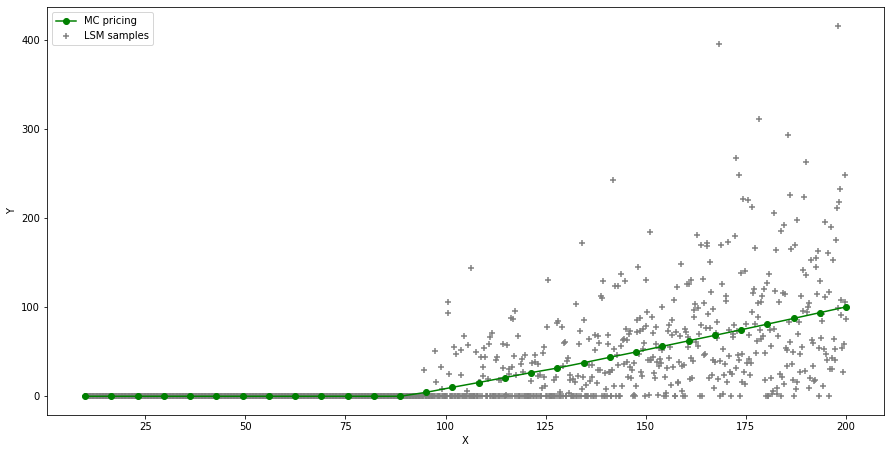

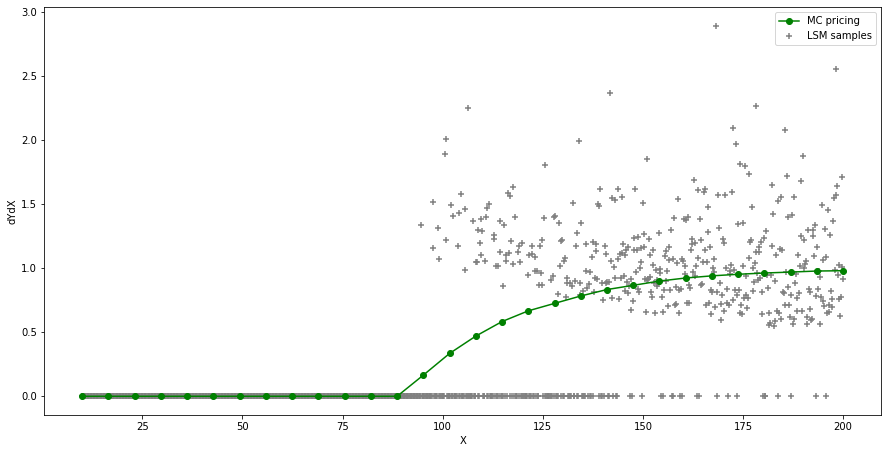

In [5]:
# Down & Out Call Option Parameters
strike = 100
barrier = 90
maturity = 1

# Heston Model Parameters
S0 = torch.tensor(100.0)
v0 = torch.tensor(0.1)
rho = torch.tensor(-0.9)
kappa = torch.tensor(0.1)
theta = torch.tensor(0.5)
sigma = torch.tensor(0.1)
risk_free_rate = torch.tensor(0.02)

# Simulations Parameters
seed = 123
nb_steps = 252
nb_simuls = 1000

# -------------------------------------------------------------------------------------------------------------------- #

# Price
start = time.perf_counter()
price = MC_Pricing(strike=strike, barrier=barrier, S0=S0.clone(), v0=v0.clone(), risk_free_rate=risk_free_rate.clone(),
                   maturity=maturity, rho=rho.clone(), kappa=kappa.clone(), theta=theta.clone(), sigma=sigma.clone(),
                   nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print("\nResults")
print(f" - Price: {price} ({round(end - start, 1)}s)")

# Delta
start = time.perf_counter()
delta = DeltaAAD(strike=strike, barrier=barrier, S0=S0.clone(), v0=v0.clone(), risk_free_rate=risk_free_rate.clone(),
                 maturity=maturity, rho=rho.clone(), kappa=kappa.clone(), theta=theta.clone(), sigma=sigma.clone(),
                 nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print(f" - Delta: {delta} ({round(end - start, 1)}s)")

# Gamma
start = time.perf_counter()
gamma = GammaAAD(strike=strike, barrier=barrier, S0=S0.clone(), v0=v0.clone(), risk_free_rate=risk_free_rate.clone(),
                 maturity=maturity, rho=rho.clone(), kappa=kappa.clone(), theta=theta.clone(), sigma=sigma.clone(),
                 nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print(f" - Gamma: {gamma} ({round(end - start, 1)}s)")

# Rho
start = time.perf_counter()
rho = RhoAAD(strike=strike, barrier=barrier, S0=S0.clone(), v0=v0.clone(), risk_free_rate=risk_free_rate.clone(),
             maturity=maturity, rho=rho.clone(), kappa=kappa.clone(), theta=theta.clone(), sigma=sigma.clone(),
             nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print(f" - Rho: {rho} ({round(end - start, 1)}s)")

# Vega
start = time.perf_counter()
vega = VegaAAD(strike=strike, barrier=barrier, S0=S0.clone(), v0=v0.clone(), risk_free_rate=risk_free_rate.clone(),
               maturity=maturity, rho=rho.clone(), kappa=kappa.clone(), theta=theta.clone(), sigma=sigma.clone(),
               nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print(f" - Vega: {vega} ({round(end - start, 1)}s)\n")

# LSM Dataset
start = time.perf_counter()
X, Y, dYdX = HestonLSM(strike=strike, barrier=barrier, v0=v0.clone(), risk_free_rate=risk_free_rate.clone(),
                       maturity=maturity, rho=rho.clone(), kappa=kappa.clone(), theta=theta.clone(), sigma=sigma.clone(),
                       nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
end = time.perf_counter()
print(f"LSM Dataset Generated ({round(end - start, 1)}s)")

# MC Dataset
start = time.perf_counter()
MC_prices = []
MC_deltas = []
S0_list = torch.linspace(10, 200, 30)
for S0 in S0_list:
    MC_prices.append(MC_Pricing(strike=strike, barrier=barrier, S0=S0.clone(), v0=v0.clone(),
                                risk_free_rate=risk_free_rate.clone(), maturity=maturity, rho=rho.clone(),
                                kappa=kappa.clone(), theta=theta.clone(), sigma=sigma.clone(), nb_steps=nb_steps,
                                nb_simuls=nb_simuls, seed=seed))
    MC_deltas.append(DeltaAAD(strike=strike, barrier=barrier, S0=S0.clone(), v0=v0.clone(),
                               risk_free_rate=risk_free_rate.clone(), maturity=maturity, rho=rho.clone(),
                               kappa=kappa.clone(), theta=theta.clone(), sigma=sigma.clone(), nb_steps=nb_steps,
                               nb_simuls=nb_simuls, seed=seed))
end = time.perf_counter()
print(f"MC Dataset Generated ({round(end - start, 1)}s)")

# Fig 1: Pricing Function
fig1, ax1 = plt.subplots(figsize=(15, 7.5))
ax1.scatter(X, Y, marker="+", color="grey", label='LSM samples')
ax1.plot(S0_list, MC_prices, marker="o", color="green", label='MC pricing')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend()

# Fig 2: Delta Function
fig2, ax2 = plt.subplots(figsize=(15, 7.5))
ax2.scatter(X, dYdX, marker="+", color="grey", label='LSM samples')
ax2.plot(S0_list, MC_deltas, marker="o", color="green", label='MC pricing')
ax2.set_xlabel('X')
ax2.set_ylabel('dYdX')
ax2.legend()

# Save Figures
if not os.path.exists('results'):
    os.makedirs('results')
fig1.savefig("results/AAD_pricing_function.png")
fig2.savefig("results/AAD_delta_function.png")

# Show Graphs
plt.show()


## 2 Pricing and hedging by differential deep learning

Class & Functions

In [6]:
class Twin_Network(nn.Module):
    def __init__(self, nb_inputs, nb_hidden_layer, nb_neurones, seed=1):
        super(Twin_Network, self).__init__()
        torch.manual_seed(seed)
        self.nb_inputs = nb_inputs
        self.nb_hidden_layer = nb_hidden_layer
        self.nb_neurones = nb_neurones
        self.layers = nn.ModuleList()
        self.cost_values = []
        self._init_layers()

    def _init_layers(self):
        # For Each Layer
        for i in range(0, self.nb_hidden_layer + 1):
            # If First Hidden Layer
            if i == 0:
                layer = nn.Linear(self.nb_inputs, self.nb_neurones)
            # If Output Layer
            elif i == self.nb_hidden_layer:
                layer = nn.Linear(self.nb_neurones, 1)
            # Else
            else:
                layer = nn.Linear(self.nb_neurones, self.nb_neurones)
            # He Initialization
            nn.init.kaiming_normal_(layer.weight, mode='fan_in')
            self.layers.append(layer)

    def forward(self, x: float):
        """
        Inputs:
         - x              : input (float)
        Outputs:
         - propagated input (float)
        """
        # Set Activation Function
        activation = nn.ReLU()
        # For Each Layer
        for layer in self.layers:
            # If Output Layer
            if layer == self.layers[-1]:
                # Forward
                x = layer(x)
            # Else
            else:
                # Forward + Activation
                x = activation(layer(x))
        return x

    def predict_price(self, X: float, X_mean: float, X_std: float, Y_mean: float, Y_std: float):
        """
        Inputs:
         - X              : initial asset spot (float)
         - X_mean         : training samples mean (float)
         - X_std          : training samples stdev (float)
         - Y_mean         : training labels mean (float)
         - Y_std          : training labels stdev (float)
        Outputs:
         - predicted price (float)
        """
        # Forward Propagation
        X = torch.tensor([X])
        X_norm = torch.div(X - X_mean, X_std)
        Y_norm = self.forward(X_norm)[0]
        Y = Y_norm * Y_std + Y_mean
        return Y

    def predict_price_and_diffs(self, X: float, X_mean: float, X_std: float, Y_mean: float, Y_std: float,
                                dYdX_mean: float, dYdX_std: float):
        """
        Inputs:
         - X              : initial asset spot (float)
         - X_mean         : training samples mean (float)
         - X_std          : training samples stdev (float)
         - Y_mean         : training labels mean (float)
         - Y_std          : training labels stdev (float)
         - dYdX_mean      : training differentials mean (float)
         - dYdX_std       : training differentials stdev (float)
        Outputs:
         - predicted payoff (float)
         - predicted delta (float)
        """
        # Forward Propagation
        X = torch.tensor([X], requires_grad=True)
        X_norm = torch.div(X - X_mean, X_std)
        Y_norm = self.forward(X_norm)[0]
        Y = Y_norm * Y_std + Y_mean
        # Backward Propagation
        Y.backward()
        dYdX_norm = X.grad[0]
        dYdX = dYdX_norm * dYdX_std + dYdX_mean
        return Y, dYdX


def MSE_standard(model: Twin_Network, X_norm: list, Y_norm: list):
    """
    Inputs:
     - model          : neural network (Twin_Network())
     - X_norm         : training samples normalized (1D tensor)
     - Y_norm         : training labels normalized (1D tensor)
    Outputs:
     - standard mean squared error (float)
    """
    loss = torch.tensor(0.0)
    for x, y in zip(X_norm, Y_norm):
        x = torch.tensor([x])
        y_pred = model(x)[0]
        loss += torch.div(torch.square(y - y_pred), len(X_norm))
    return loss


def MSE_differential(model: Twin_Network, X_norm: list, Y_norm: list, dYdX_norm: list, lambda_j: float, alpha: float):
    """
    Inputs:
     - model          : neural network (Twin_Network())
     - X_norm         : training samples normalized (1D tensor)
     - Y_norm         : training labels normalized (1D tensor)
     - dYdX_norm      : training differentials normalized (1D tensor)
     - lambda_j       : cost function differential weight (float)
     - alpha          : cost function differential factor (float)
    Outputs:
     - differential mean squared error (float)
    """
    loss = alpha * MSE_standard(model, X_norm, Y_norm)
    if alpha != 1:
        ds = pow(10, -4)
        for x, z in zip(X_norm, dYdX_norm):
            x_plus = torch.tensor([x+ds], requires_grad=True)
            x_neg = torch.tensor([x-ds], requires_grad=True)
            y_pred_plus = model(x_plus)[0]
            y_pred_neg = model(x_neg)[0]
            z_pred = (y_pred_plus - y_pred_neg) / (2*ds)
            loss += torch.div(torch.square(z - z_pred), len(X_norm)) * lambda_j * (1 - alpha)
    return loss


def training(model: Twin_Network, X_norm: list, Y_norm: list, nb_epochs: int, dYdX_norm=None, lambda_j=None):
    """
    Inputs:
     - model          : neural network (Twin_Network())
     - X_norm         : normalized training samples (1D tensor)
     - Y_norm         : normalized training labels (1D tensor)
     - nb_epochs      : number of training iterations (int)
     - dYdX_norm      : normalized pathwise differentials (1D tensor)
     - lambda_j       : cost function differential weight (float)
    Outputs:
     - trained model (Twin_Network())
    """
    # Cost Function
    if dYdX_norm is None:
        alpha = 1
    else:
        alpha = 1 / (1 + model.nb_inputs)
    # Cost Function
    criterion = MSE_differential
    # Optimizer
    optimizer = optim.Adam(params=model.parameters(), lr=0.1)
    # Optimization Loop
    for i in range(0, nb_epochs):
        optimizer.zero_grad()
        loss = criterion(model, X_norm, Y_norm, dYdX_norm, lambda_j, alpha)
        # Update Weights
        loss.backward()
        optimizer.step()
        # Store Cost Value
        model.cost_values.append(loss.item())
    return model


Main


Normalized Training Set Generated (34.3s)
Classic NN Trained (37.3s)
Differential NN Trained (113.4s)
Classic NN Pricing (0.0s)
Differential NN Pricing (0.0s)

Results:
 - Classic NN Price: 12.607839623373394
 - Classic NN FD Delta: 3.1917557361182958
 - Classic NN Final Cost: 0.5233866572380066
 - Differential NN Price: 14.828242390890983
 - Differential NN Delta: 0.6200239658355713
 - Differential NN FD Delta: 0.28944843685430044
 - Differential NN Final Cost: 0.6406592130661011


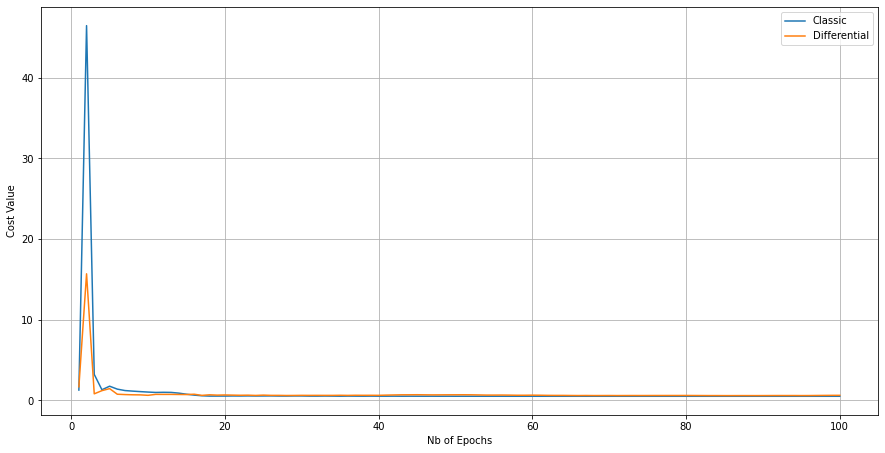

In [7]:
# Down & Out Call Option Parameters
strike = 100
barrier = 90
maturity = 1

# Heston Model Parameters
S0 = torch.tensor(100.0)
v0 = torch.tensor(0.1)
rho = torch.tensor(-0.9)
kappa = torch.tensor(0.1)
theta = torch.tensor(0.5)
sigma = torch.tensor(0.1)
risk_free_rate = torch.tensor(0.02)

# Simulations Parameters
seed = 123
nb_steps = 252
nb_simuls = 1000

# Neural Network Parameters
nb_hidden_layers = 4
nb_neurones = 20
nb_epochs = 100

# FD Step
dS0 = pow(10, -4)

# -------------------------------------------------------------------------------------------------------------------- #

# Generate Normalized Training Set
start = time.perf_counter()
X, Y, dYdX = HestonLSM(strike=strike, barrier=barrier, v0=v0.clone(), risk_free_rate=risk_free_rate.clone(),
                       maturity=maturity, rho=rho.clone(), kappa=kappa.clone(), theta=theta.clone(),
                       sigma=sigma.clone(), nb_steps=nb_steps, nb_simuls=nb_simuls, seed=seed)
X_mean, X_std, X_norm, Y_mean, Y_std, Y_norm, dYdX_mean, dYdX_std, dYdX_norm, lambda_j = normalize_data(X, Y, dYdX)
end = time.perf_counter()
print(f"\nNormalized Training Set Generated ({round(end - start, 1)}s)")

# Train Classic Neural Network
start = time.perf_counter()
classic_nn = Twin_Network(nb_inputs=1, nb_hidden_layer=nb_hidden_layers, nb_neurones=nb_neurones, seed=seed)
classic_nn = training(model=classic_nn, X_norm=X_norm, Y_norm=Y_norm, nb_epochs=nb_epochs)
end = time.perf_counter()
print(f"Classic NN Trained ({round(end - start, 1)}s)")

# Train Differential Neural Network
start = time.perf_counter()
differential_nn = Twin_Network(nb_inputs=1, nb_hidden_layer=nb_hidden_layers, nb_neurones=nb_neurones, seed=seed)
differential_nn = training(model=differential_nn, X_norm=X_norm, Y_norm=Y_norm, nb_epochs=nb_epochs,
                           dYdX_norm=dYdX_norm, lambda_j=lambda_j)
end = time.perf_counter()
print(f"Differential NN Trained ({round(end - start, 1)}s)")

# Price Classic Neural Network
start = time.perf_counter()
classic_nn_price = classic_nn.predict_price(S0, X_mean, X_std, Y_mean, Y_std)
classic_nn_price_up = classic_nn.predict_price(S0+dS0, X_mean, X_std, Y_mean, Y_std)
classic_nn_price_down = classic_nn.predict_price(S0-dS0, X_mean, X_std, Y_mean, Y_std)
classic_nn_delta_FD = (classic_nn_price_up - classic_nn_price_down) / (2*dS0)
end = time.perf_counter()
print(f"Classic NN Pricing ({round(end - start, 1)}s)")

# Price Differentiated Neural Network
start = time.perf_counter()
differential_nn_price, differential_nn_delta_NN = \
    differential_nn.predict_price_and_diffs(S0, X_mean, X_std, Y_mean, Y_std, dYdX_mean, dYdX_std)
differential_nn_price_up, _ = \
    differential_nn.predict_price_and_diffs(S0+dS0, X_mean, X_std, Y_mean, Y_std, dYdX_mean, dYdX_std)
differential_nn_price_down, _ = \
    differential_nn.predict_price_and_diffs(S0-dS0, X_mean, X_std, Y_mean, Y_std, dYdX_mean, dYdX_std)
differential_nn_delta_FD = (differential_nn_price_up - differential_nn_price_down) / (2*dS0)
end = time.perf_counter()
print(f"Differential NN Pricing ({round(end - start, 1)}s)")

# Plot NN Training Cost Evolution
fig1, ax1 = plt.subplots(figsize=(15, 7.5))
ax1.plot(range(1, nb_epochs+1), classic_nn.cost_values, label="Classic")
ax1.plot(range(1, nb_epochs+1), differential_nn.cost_values, label="Differential")
ax1.set_xlabel("Nb of Epochs")
ax1.set_ylabel("Cost Value")
ax1.legend()
ax1.grid()
fig1.savefig("results/NN_training_cost.png")

# Display Results
print("\nResults:")
print(f" - Classic NN Price: {classic_nn_price}")
print(f" - Classic NN FD Delta: {classic_nn_delta_FD}")
print(f" - Classic NN Final Cost: {classic_nn.cost_values[-1]}")
print(f" - Differential NN Price: {differential_nn_price}")
print(f" - Differential NN Delta: {differential_nn_delta_NN}")
print(f" - Differential NN FD Delta: {differential_nn_delta_FD}")
print(f" - Differential NN Final Cost: {differential_nn.cost_values[-1]}")

# Display Graphs
plt.show()
